# Sequence specificities of RNA-binding proteins with convolutional neural networks

In this tutorial, we will walk through an example of how use deepomics to build, train, and evaluate a convolutional neural network for a common supervised regression learning task of predicting the sequence specificity of a RNA binding protein twoards RNA probe sequences in the RNAcompete dataset. Deepomics is a higher level API that allows you to quickly build different neural network architectures, modify hyperparameters all while keeping track of the feed_dict.  It also allows for easier evaluation of neural networks for biological sequence data. 

To get deepomics:

! git clone https://github.com/p-koo/deepomics

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys, h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from deepomics import neuralnetwork as nn
from deepomics import utils, fit, visualize, saliency

# Load an RNAcompete experiment

The sequences were preprocessed by converting the sequences to a one-hot representation.  The affinity intensities were normalized with a log-transformation (details are not important for this tutorial).  

In [2]:
# path to dataset 
data_file_path = '../data/VTS1.h5'

# load dataset
dataset = h5py.File(data_file_path, 'r')
X_train = np.array(dataset['X_train']).astype(np.float32)
Y_train = np.array(dataset['Y_train']).astype(np.float32)
X_valid = np.array(dataset['X_valid']).astype(np.float32)
Y_valid = np.array(dataset['Y_valid']).astype(np.float32)
X_test = np.array(dataset['X_test']).astype(np.float32)
Y_test = np.array(dataset['Y_test']).astype(np.float32)

# add another dimension to make it a 4D tensor and 
# transpose dimensions so that it matches convolutional layer inputs:
#                  (batch size, sequence length, 1, nucleotide channels)
#    Note: adding an additional dimension is required because we will be using 2D convolution functions,
#          because tensorflow doesn't support a lot of functions for 1D sequences.  Effectively, its like
#          treating second dimension as an image with one pixel in one axis.
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_valid = np.expand_dims(X_valid, axis=2)


# Note: deepomics takes as input a dictionary for each dataset
train = {'inputs': X_train, 'targets': Y_train}
valid = {'inputs': X_valid, 'targets': Y_valid}
test = {'inputs': X_test, 'targets': Y_test}

# build our convolutional neural network model 

Our model will be similar to DeepBind: one convolutional layer, one fully-connected hidden layer, followed by an output layer.  Note that the major difference between this CNN and the one for TFs is that here we need to perform a regression task.  So, the output activation is linear and the objective is now a squared_error.  

In [3]:
def cnn_model(input_shape, output_shape):
    
    layer1 = {'layer': 'input', #200          
              'input_shape': input_shape
             }
    layer2 = {'layer': 'conv1d',
              'num_filters': 32,
              'filter_size': 12,
              'norm': 'batch',          # if removed, automatically adds bias instead
              'activation': 'relu',     # or leaky_relu, prelu, sigmoid, tanh, etc
              'dropout': 0.2,           # if removed, default is no dropout
              'padding': 'VALID',        # VALID OR SAME
              'max_pool': 10,           # 4
             }
    layer3 = {'layer': 'dense',
              'num_units': 128,
              'norm': 'batch',
              'activation': 'relu',
              'dropout': 0.5,
             }
    layer4 = {'layer': 'dense',
              'num_units': output_shape[1],
              'activation': 'linear'
             }

    model_layers = [layer1, layer2, layer3, layer4]

    # optimization parameters
    optimization = {"objective": "squared_error",
                    "optimizer": "adam",
                    "learning_rate": 0.0003,
                    "l2": 1e-6,
                    #"label_smoothing": 0.05,
                    #"l1": 1e-6,
                    }
    return model_layers, optimization


# get shapes of inputs and targets
input_shape = list(train['inputs'].shape)
input_shape[0] = None
output_shape = train['targets'].shape

# load model parameters
model_layers, optimization = cnn_model(input_shape, output_shape)

# build neural network class
nnmodel = nn.NeuralNet(seed=247)
nnmodel.build_layers(model_layers, optimization)

# compile neural trainer
save_path = utils.make_directory('../results', 'VTS1')
param_path = os.path.join(save_path, 'deepomics_cnn')
nntrainer = nn.NeuralTrainer(nnmodel, save='best', file_path=param_path)

making directory: ../results/VTS1


In [4]:
# look at the shapes of each layer
nnmodel.inspect_layers()

----------------------------------------------------------------------------
Network architecture:
----------------------------------------------------------------------------
layer1: inputs
(?, 39, 1, 6)
layer2: conv1d_0
(?, 28, 1, 32)
layer3: conv1d_0_batch
(?, 28, 1, 32)
layer4: conv1d_0_active
(?, 28, 1, 32)
layer5: conv1d_0_maxpool
(?, 3, 1, 32)
layer6: conv1d_0_dropout
(?, 3, 1, 32)
layer7: dense_0
(?, 128)
layer8: dense_0_batch
(?, 128)
layer9: dense_0_active
(?, 128)
layer10: dense_0_dropout
(?, 128)
layer11: dense_1
(?, 1)
layer12: dense_1_bias
(?, 1)
layer13: output
(?, 1)
----------------------------------------------------------------------------


# start a session

In [5]:
# initialize session
sess = utils.initialize_session()

# train the neural network

In [6]:
# fit model
data = {'train': train, 'valid': valid}
fit.train_minibatch(sess, nntrainer, data, 
                    batch_size=100, 
                    num_epochs=50,
                    patience=10, 
                    verbose=2, 
                    shuffle=True, 
                    save_all=False)

Epoch 1 out of 50 
[==============================] 100.0% -- time=4s -- loss=1.39571 
  valid loss:		0.89136
  valid Pearson's R:	0.40066+/-0.00000
  valid rsquare:	0.11470+/-0.00000
  valid slope:		0.75405+/-0.00000
  lower cross-validation found
  saving model to:  ../results/VTS1/deepomics_cnn_best.ckpt
Epoch 2 out of 50 
[==============================] 100.0% -- time=4s -- loss=0.89388 
  valid loss:		0.76986
  valid Pearson's R:	0.50402+/-0.00000
  valid rsquare:	0.22624+/-0.00000
  valid slope:		1.05449+/-0.00000
  lower cross-validation found
  saving model to:  ../results/VTS1/deepomics_cnn_best.ckpt
Epoch 3 out of 50 
[==============================] 100.0% -- time=4s -- loss=0.81225 
  valid loss:		0.75278
  valid Pearson's R:	0.54527+/-0.00000
  valid rsquare:	0.24379+/-0.00000
  valid slope:		0.93813+/-0.00000
  lower cross-validation found
  saving model to:  ../results/VTS1/deepomics_cnn_best.ckpt
Epoch 4 out of 50 
[==============================] 100.0% -- time=4s -- 

[==============================] 100.0% -- time=4s -- loss=0.54371 
  valid loss:		0.54153
  valid Pearson's R:	0.68162+/-0.00000
  valid rsquare:	0.45905+/-0.00000
  valid slope:		1.08380+/-0.00000
Epoch 33 out of 50 
[==============================] 100.0% -- time=4s -- loss=0.53709 
  valid loss:		0.55718
  valid Pearson's R:	0.68082+/-0.00000
  valid rsquare:	0.44461+/-0.00000
  valid slope:		1.11165+/-0.00000
Epoch 34 out of 50 
[==============================] 100.0% -- time=4s -- loss=0.53938 
  valid loss:		0.54992
  valid Pearson's R:	0.67991+/-0.00000
  valid rsquare:	0.45351+/-0.00000
  valid slope:		1.13152+/-0.00000
Epoch 35 out of 50 
[==============================] 100.0% -- time=4s -- loss=0.53896 
  valid loss:		0.53927
  valid Pearson's R:	0.68513+/-0.00000
  valid rsquare:	0.46102+/-0.00000
  valid slope:		1.08376+/-0.00000
Epoch 36 out of 50 
[==============================] 100.0% -- time=4s -- loss=0.53642 
  valid loss:		0.53969
  valid Pearson's R:	0.68121+/-0.

In [7]:
# set best parameters
nntrainer.set_best_parameters(sess)

# test model
loss, mean_vals, std_vals = nntrainer.test_model(sess, test, name='test')

loading model from:  ../results/VTS1/deepomics_cnn_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/VTS1/deepomics_cnn_best.ckpt
  test  loss:		0.56301
  test  Pearson's R:	0.66325+/-0.00000
  test  rsquare:	0.43728+/-0.00000
  test  slope:		1.02954+/-0.00000


# get predictions

Note: the activations of any layer can be extracted by giving the layer name.

/usr/lib/python2.7/dist-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


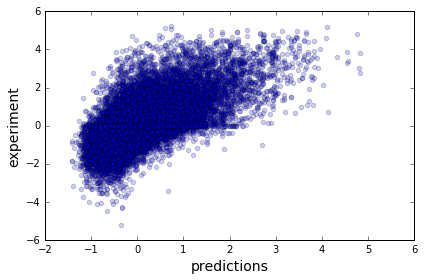

In [8]:
# calculate activations
predictions = nntrainer.get_activations(sess, test, layer='output')

plt.figure()
plt.scatter(predictions[:,0], test['targets'][:,0], alpha=0.2)
plt.xlabel('predictions', fontsize=14)
plt.ylabel('experiment', fontsize=14)


# close session

In [9]:
# close session
sess.close()

# Let's plot saliency maps for the highest predicted sequences

INFO:tensorflow:Restoring parameters from ../results/VTS1/deepomics_cnn_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/VTS1/deepomics_cnn_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/VTS1/deepomics_cnn_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/VTS1/deepomics_cnn_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/VTS1/deepomics_cnn_best.ckpt


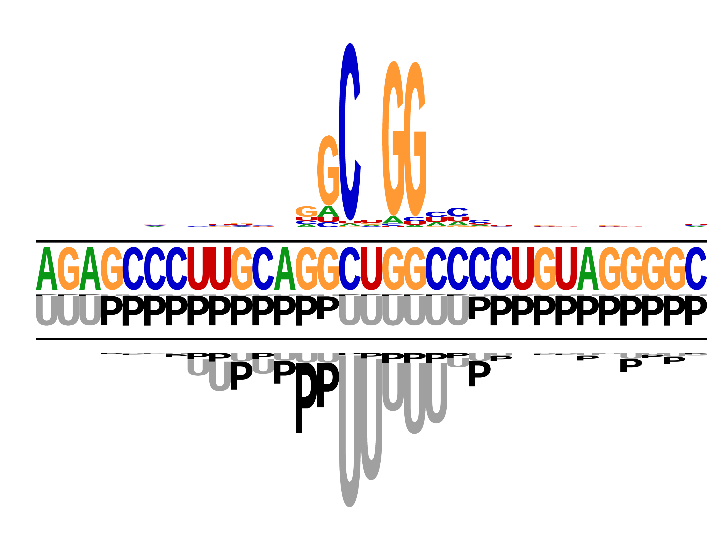

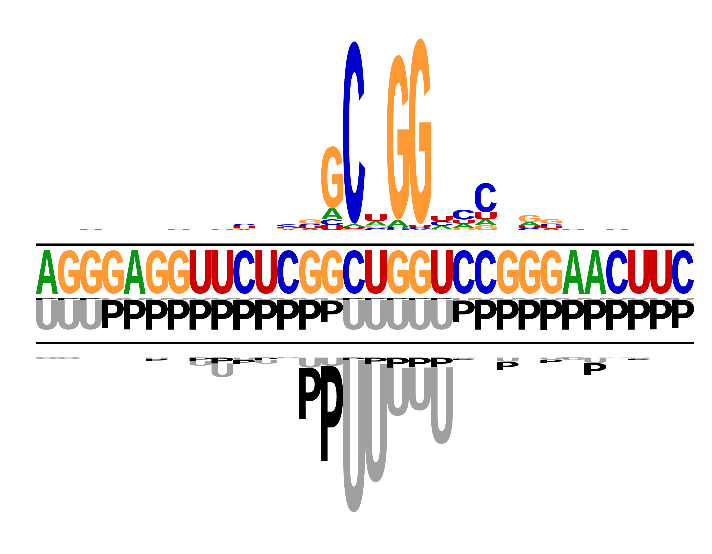

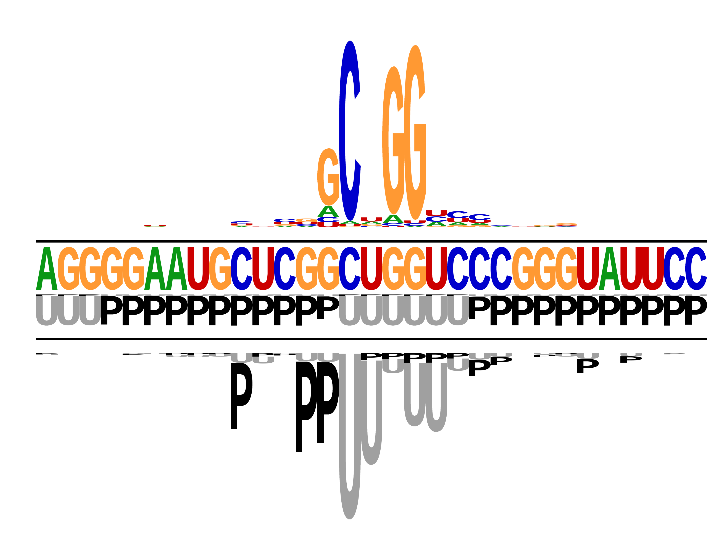

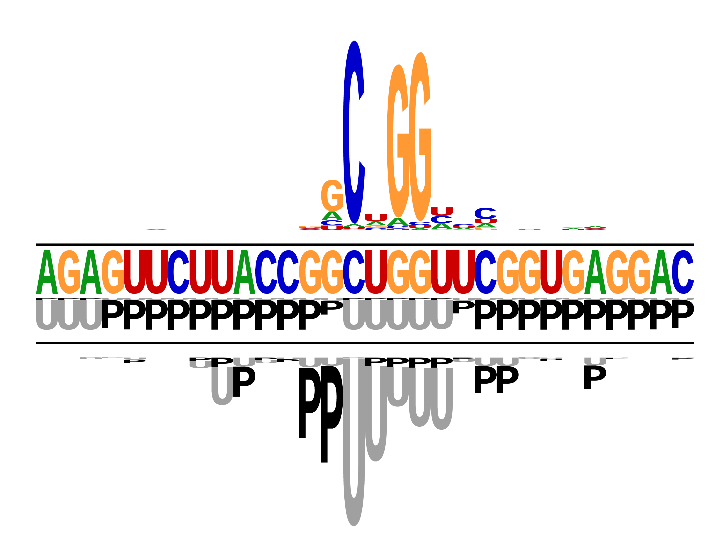

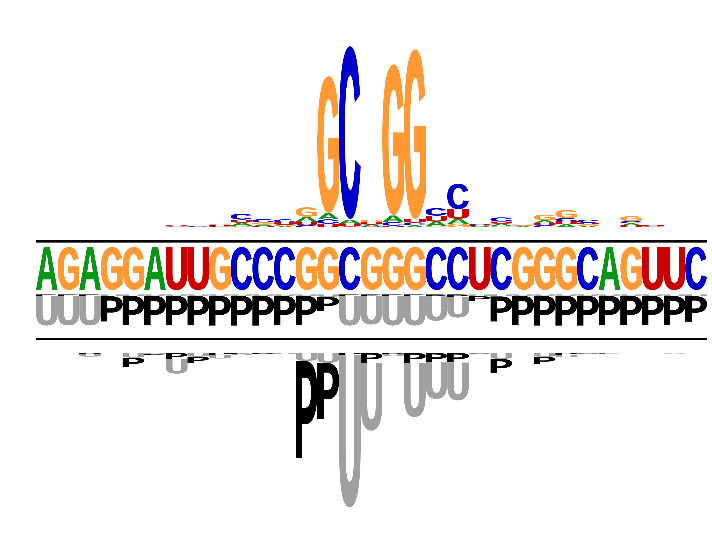

In [10]:
# sort activations
plot_index = np.argsort(predictions[:,0])[::-1]

# saliency parameters
params = {'genome_model': cnn_model, 
          'input_shape': input_shape, 
          'output_shape': output_shape, 
          'optimization': optimization,
          'model_path': param_path+'_best.ckpt',
         }

# plot saliency of top activations
num_plots = 5
for index in plot_index[:num_plots]:

        X = np.expand_dims(test['inputs'][index], axis=0)

        # guided backprop
        guided_saliency = saliency.guided_backprop(X, layer='output', class_index=None, params=params)

        # plot and save saliency
        fig = plt.figure(figsize=(10,10))
        visualize.plot_seq_struct_saliency(np.squeeze(X).T, 
                                            np.squeeze(guided_saliency[0]).T, 
                                            nt_width=100)
            #outfile = os.path.join(save_path, str(index)+'_saliency_.pdf')
        #fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight') 
        #plt.close()